![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importación librerías
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import joblib
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

In [8]:
# Visualización datos de entrenamiento
dataTraining.head()

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27


In [9]:
# Visualización datos de test
dataTesting.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


# Preprocesamiento de los datos

Primero observaremos las caracteristicas del set de datos

In [12]:
dataTraining.shape

(79800, 21)

El dataset contiene 21 columnas y 79800 registros

In [14]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        79800 non-null  int64  
 1   track_id          79800 non-null  object 
 2   artists           79800 non-null  object 
 3   album_name        79800 non-null  object 
 4   track_name        79800 non-null  object 
 5   duration_ms       79800 non-null  int64  
 6   explicit          79800 non-null  bool   
 7   danceability      79800 non-null  float64
 8   energy            79800 non-null  float64
 9   key               79800 non-null  int64  
 10  loudness          79800 non-null  float64
 11  mode              79800 non-null  int64  
 12  speechiness       79800 non-null  float64
 13  acousticness      79800 non-null  float64
 14  instrumentalness  79800 non-null  float64
 15  liveness          79800 non-null  float64
 16  valence           79800 non-null  float6

El dataset no contiene valores nulos

In [16]:
dataTraining.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
popularity          0
dtype: int64

Valores duplicados

In [18]:
duplicados = dataTraining[dataTraining.duplicated(subset='track_id', keep=False)].sort_values(by='track_id')
duplicados

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
37758,37758,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.316000,0.000001,0.1170,0.406,143.064,4,soul,0
26786,26786,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.316000,0.000001,0.1170,0.406,143.064,4,chill,0
39619,39619,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.019400,0.088100,0.3290,0.700,183.571,1,punk-rock,38
78451,78451,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.019400,0.088100,0.3290,0.700,183.571,1,ska,38
58237,58237,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.001210,0.000000,0.0995,0.236,148.033,4,alt-rock,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,314,7zv2vmZq8OjS54BxFzI2wM,Attila,Soundtrack to a Party (Bonus),Lets Start the Party,125859,True,0.592,0.932,1,-5.412,1,0.0558,0.000005,0.859000,0.0730,0.677,133.987,4,metalcore,25
24108,24108,7zv2vmZq8OjS54BxFzI2wM,Attila,Soundtrack to a Party (Bonus),Lets Start the Party,125859,True,0.592,0.932,1,-5.412,1,0.0558,0.000005,0.859000,0.0730,0.677,133.987,4,death-metal,25
45951,45951,7zwn1eykZtZ5LODrf7c0tS,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,153000,False,0.551,0.881,7,-6.099,0,0.0542,0.186000,0.079100,0.1520,0.387,88.036,4,rock,83
1105,1105,7zwn1eykZtZ5LODrf7c0tS,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,153000,False,0.551,0.881,7,-6.099,0,0.0542,0.186000,0.079100,0.1520,0.387,88.036,4,alternative,83


Duplicados por track_id

In [20]:
dataTraining['track_id'].value_counts()[lambda x: x > 1]

track_id
5ftfVzSLIi5ZxYdNbRtf41    7
0WaaPFt4Qy8sVfxKz43bCD    6
434VcYrm3FPRRiW4jw5nLb    6
6bzWr3EpSEolVwlbLk58il    6
1uOe9m9bAiAY4kGnGDu1Ns    6
                         ..
2i0hWBMyrOXnGv3jWji0Lw    2
2YYVPeCDpnCKo7mMnY4T4m    2
3yHH3LPyinYelEnaj15yKb    2
3KN8XPsoTfqgBROxNW6Gce    2
5yNfMRJ8byUpEscMcy1ZXb    2
Name: count, Length: 9826, dtype: int64

Total de duplicados (excluyendo el primer valor)

In [22]:
dataTraining.duplicated(subset='track_id').sum()

13080

No se eliminan duplicados porque el genero es diferente

Valores únicos por columna

In [25]:
print(dataTraining.nunique())

Unnamed: 0          79800
track_id            66720
artists             25775
album_name          37315
track_name          55767
duration_ms         40712
explicit                2
danceability         1120
energy               1932
key                    12
loudness            17562
mode                    2
speechiness          1454
acousticness         4856
instrumentalness     5252
liveness             1706
valence              1737
tempo               37292
time_signature          5
track_genre           114
popularity            101
dtype: int64


Estadisticas descriptivas del set de entrenamiento

In [27]:
dataTraining.describe()

,Unnamed: 0,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,79800.000000,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,39899.500000,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,33.265301
std,23036.420078,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,22.330871
min,0.000000,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19949.750000,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,17.000000
50%,39899.500000,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,35.000000
75%,59849.250000,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,50.000000
max,79799.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,100.000000


Identificación de variables continuas

In [29]:
variables_continuas = [
    'duration_ms',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'popularity'
]

Distribución de las variables continuas

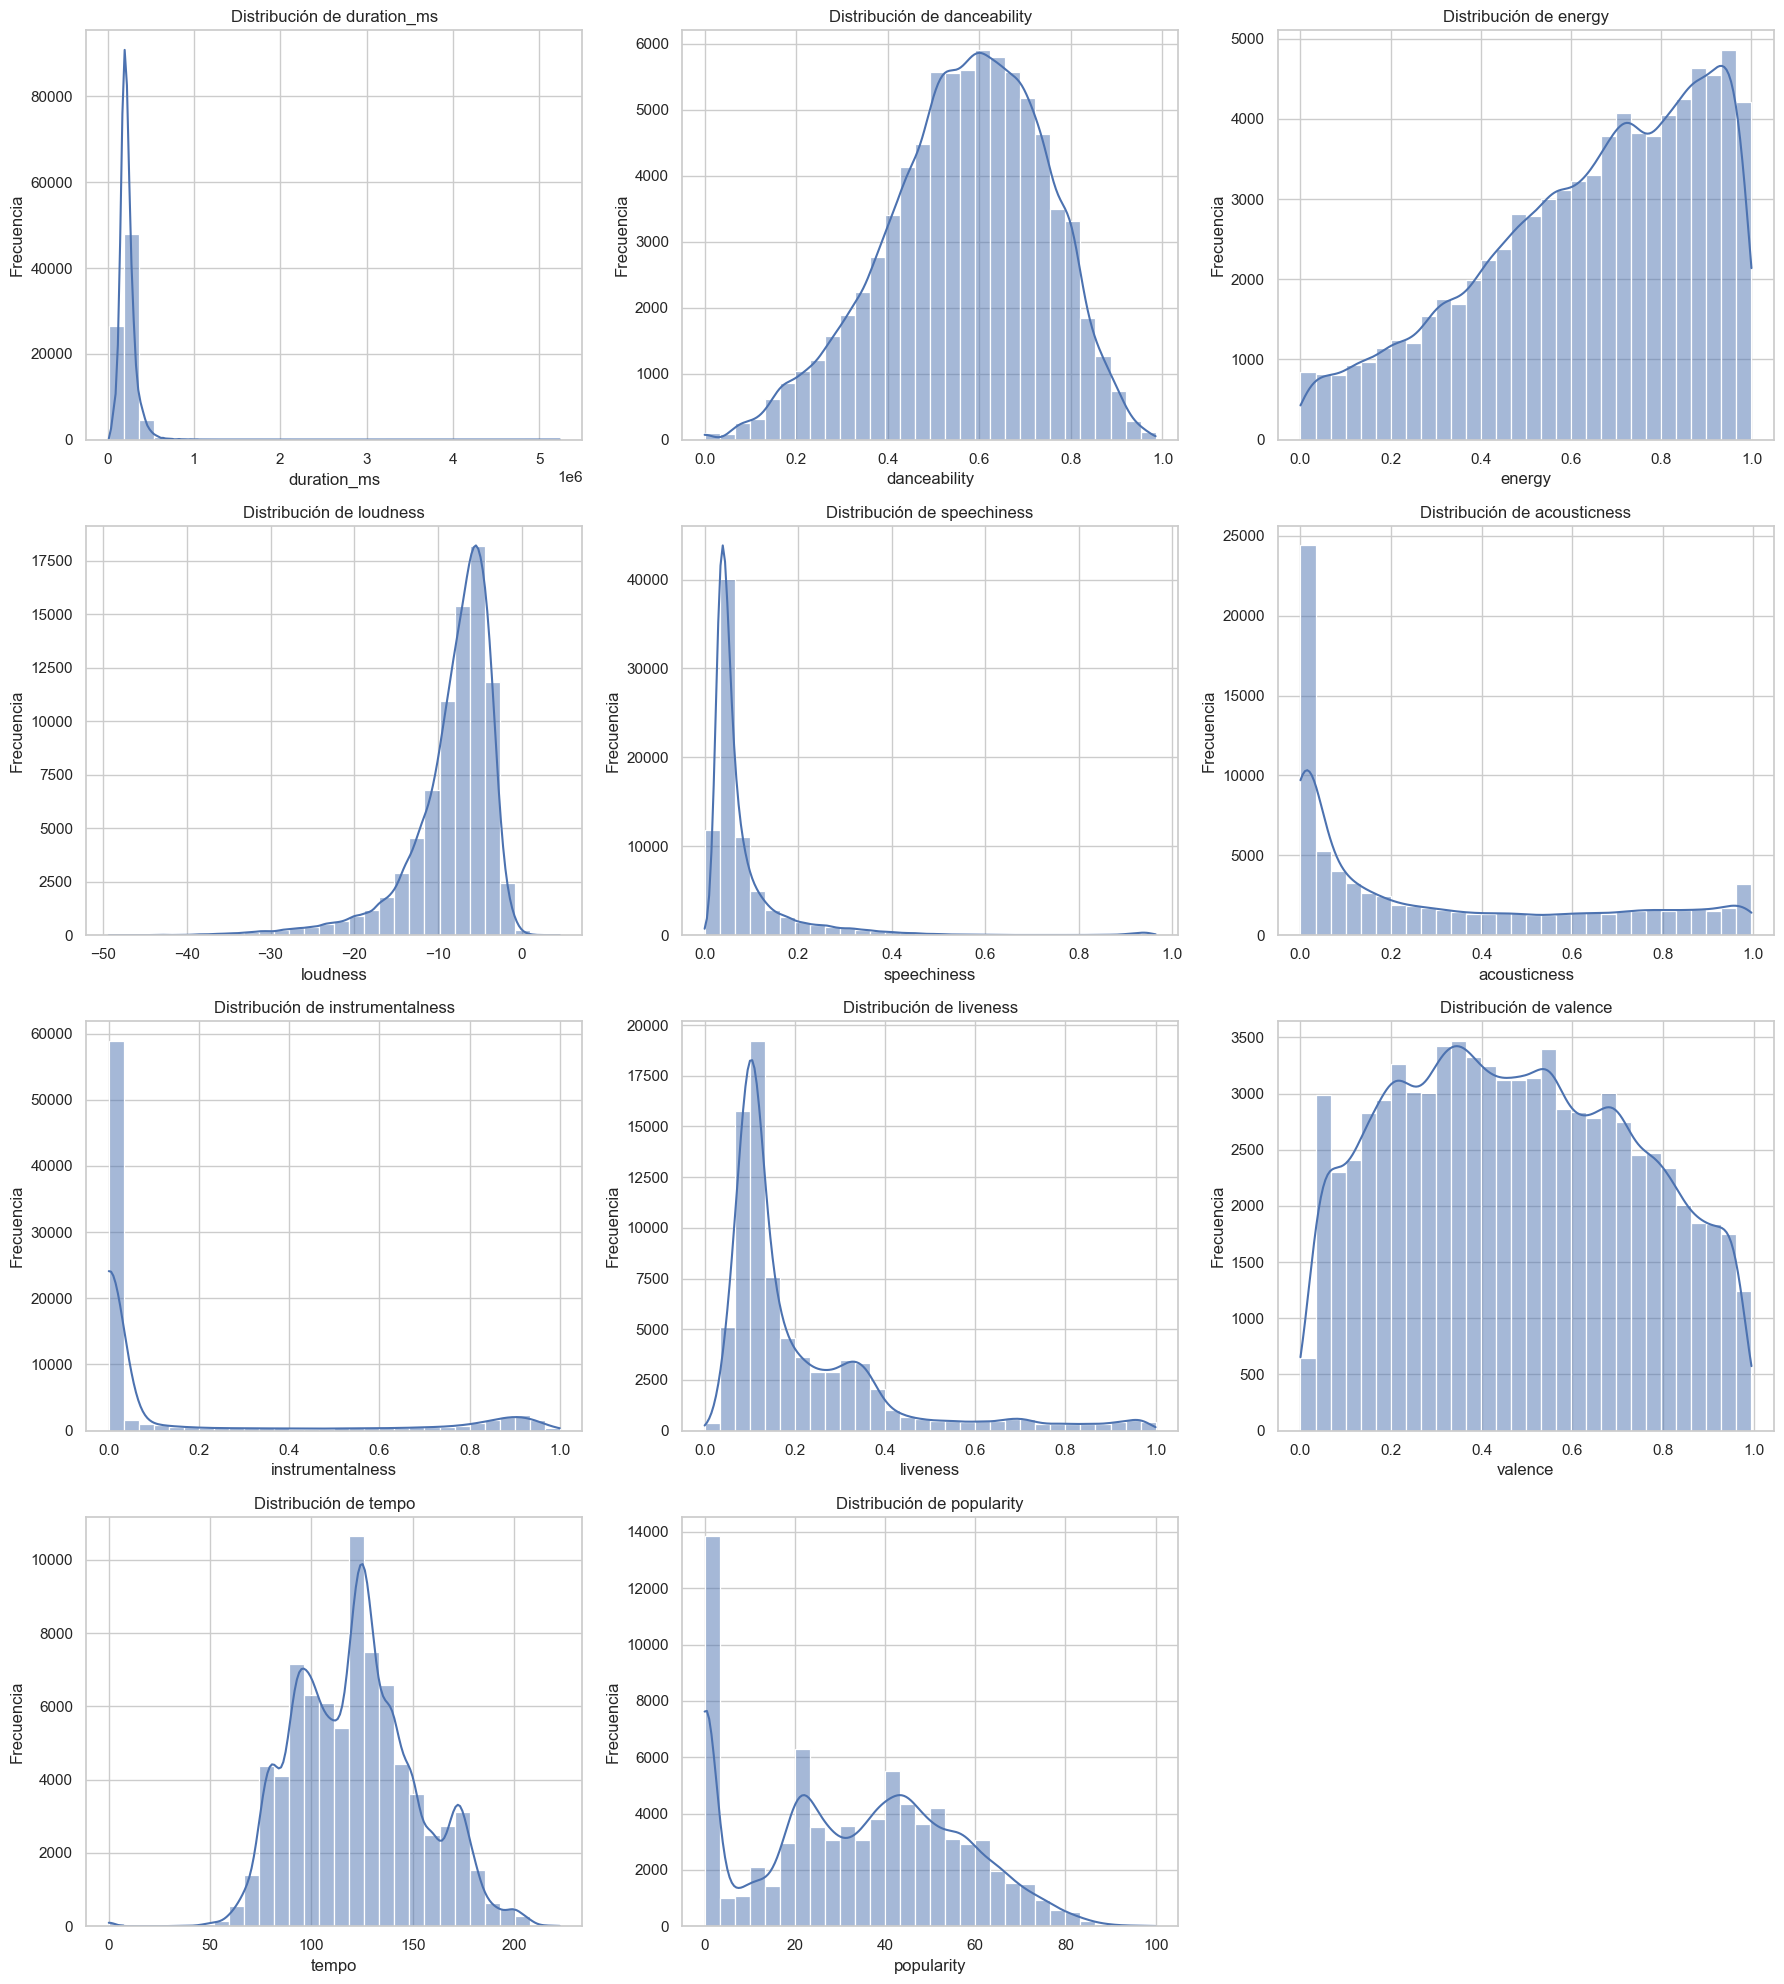

In [31]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 20))

for i, var in enumerate(variables_continuas):
    plt.subplot((len(variables_continuas) + 2) // 3, 3, i + 1)
    sns.histplot(dataTraining[var], kde=True, bins=30)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Correlación entre variables continuas (incluye Popularity)

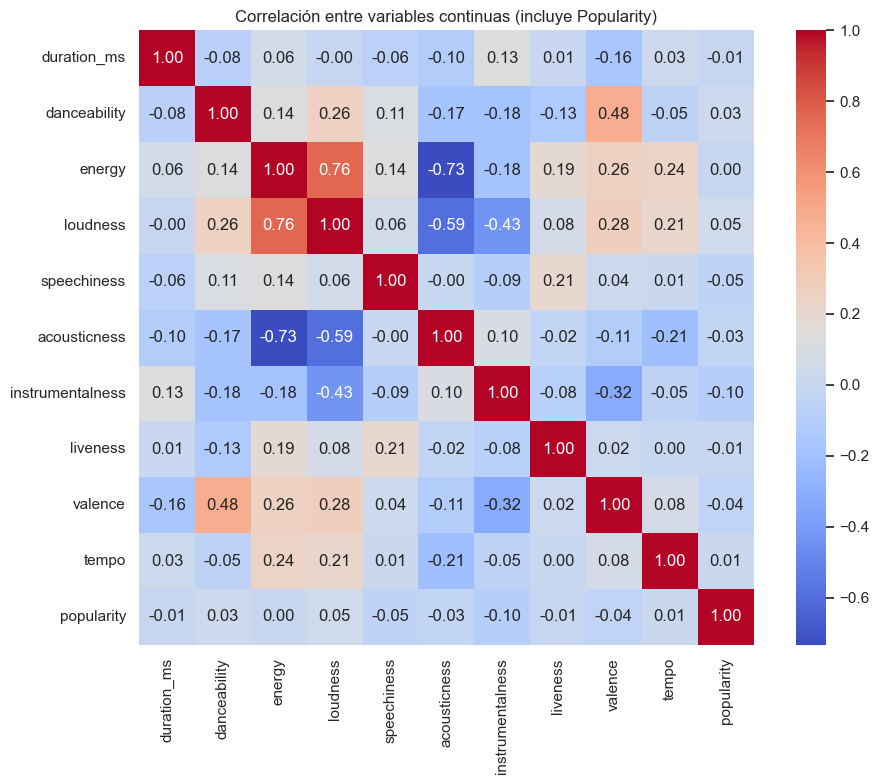

In [33]:
df_continuas = dataTraining[variables_continuas]
correlation_matrix = df_continuas.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlación entre variables continuas (incluye Popularity)')
plt.tight_layout()
plt.show()

Correlación de cada variable con 'popularity'

In [35]:
correlaciones = dataTraining[variables_continuas].corr()
correlacion_popularity = correlaciones['popularity'].drop('popularity')  # quitamos la diagonal
correlacion_ordenada = correlacion_popularity.sort_values(ascending=False)
print("🔎 Correlación de cada variable con 'popularity' (ordenadas):")
display(correlacion_ordenada)

🔎 Correlación de cada variable con 'popularity' (ordenadas):


loudness            0.051884
danceability        0.034825
tempo               0.013556
energy              0.001185
liveness           -0.007030
duration_ms        -0.008599
acousticness       -0.027883
valence            -0.041287
speechiness        -0.045089
instrumentalness   -0.095845
Name: popularity, dtype: float64

Identificación de variables binarias o ordinales

In [37]:
variables_binarias_o_ordinales = [
    'explicit',     # booleana (0/1)
    'key',          # 12 valores → notas musicales
    'mode',         # 0 o 1 → menor/mayor
    'time_signature'  # de 3 a 7
]

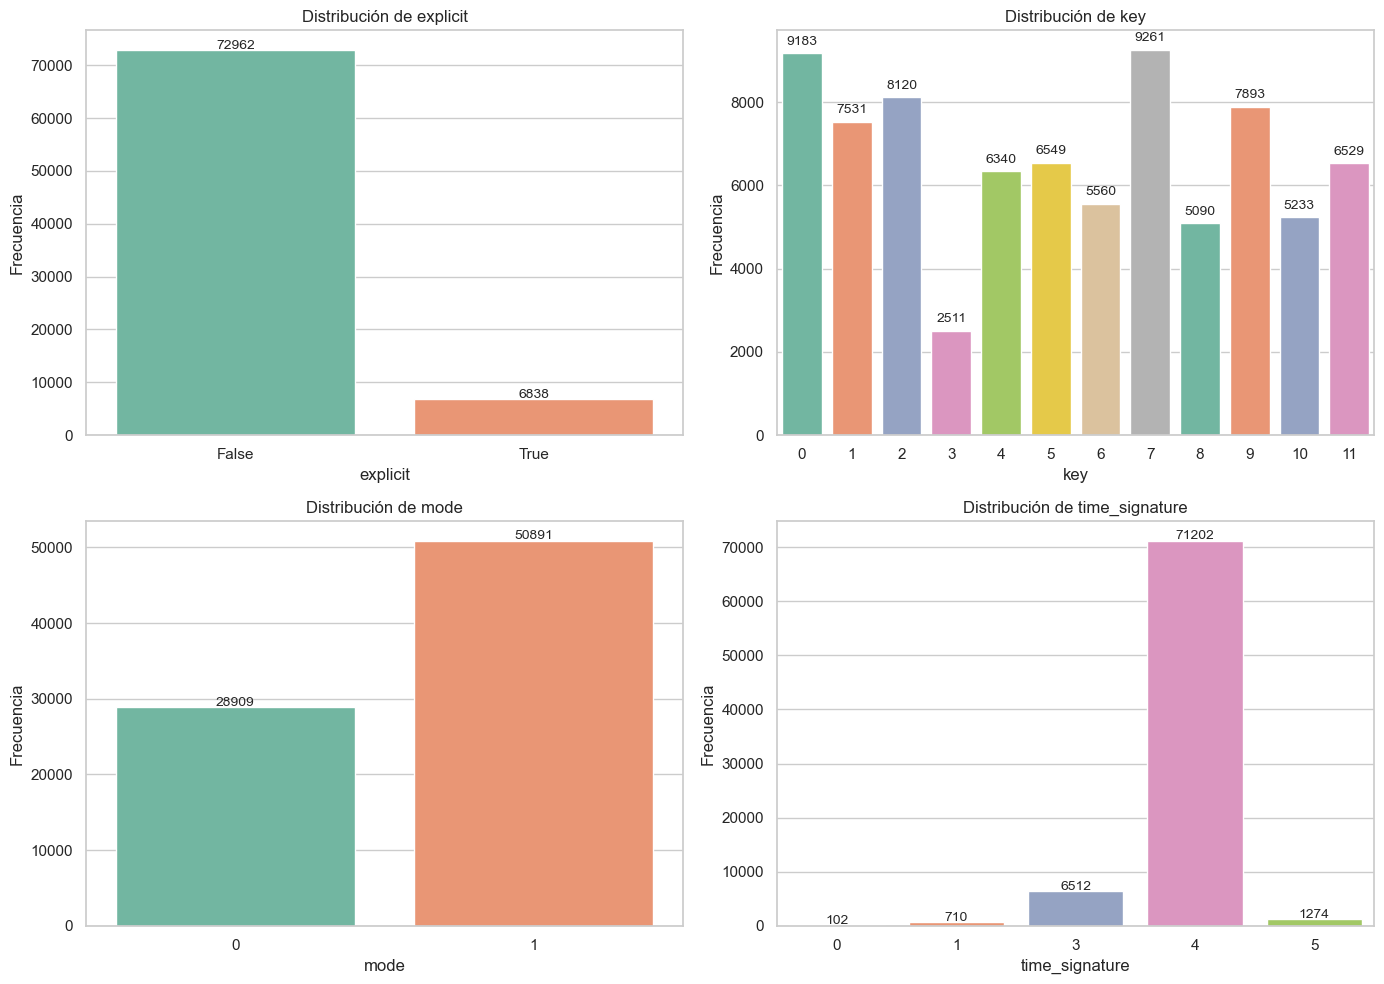

In [38]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(variables_binarias_o_ordinales):
    plt.subplot(2, 2, i + 1)
    ax = sns.countplot(data=dataTraining, x=col, palette='Set2')
    
    # Agregar etiquetas de conteo sobre las barras
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 200, int(height), ha="center", fontsize=10)
    
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [39]:
print("Correlación de Pearson con 'popularity':\n")
for var in variables_binarias_o_ordinales:
    correlacion = dataTraining[[var, 'popularity']].corr().iloc[0, 1]
    print(f"{var:<15}: {correlacion:.4f}")

Correlación de Pearson con 'popularity':

explicit       : 0.0435
key            : -0.0025
mode           : -0.0153
time_signature : 0.0331


In [40]:
print("\nCorrelación de Spearman con 'popularity':\n")
for var in variables_binarias_o_ordinales:
    correlacion = dataTraining[[var, 'popularity']].corr(method='spearman').iloc[0, 1]
    print(f"{var:<15}: {correlacion:.4f}")


Correlación de Spearman con 'popularity':

explicit       : 0.0392
key            : -0.0012
mode           : -0.0157
time_signature : 0.0391


Identificación de las variables categóricas

In [42]:
variables_categoricas = [
    'artists',      # 25.775 únicos → hay que procesar - muchos valores únicos → no graficamos directamente
    'album_name',   # 37.315 únicos → muy alta cardinalidad - muchos valores únicos → tampoco se grafica tal cual
    'track_name',   # 55.767 únicos → no usar directamente - texto libre único → no se grafica
    'track_genre'   # 114 → se puede codificar o agrupar - sí se puede graficar (114 valores)
]

Las 10 categorias más frecuentes de las variables categóricas

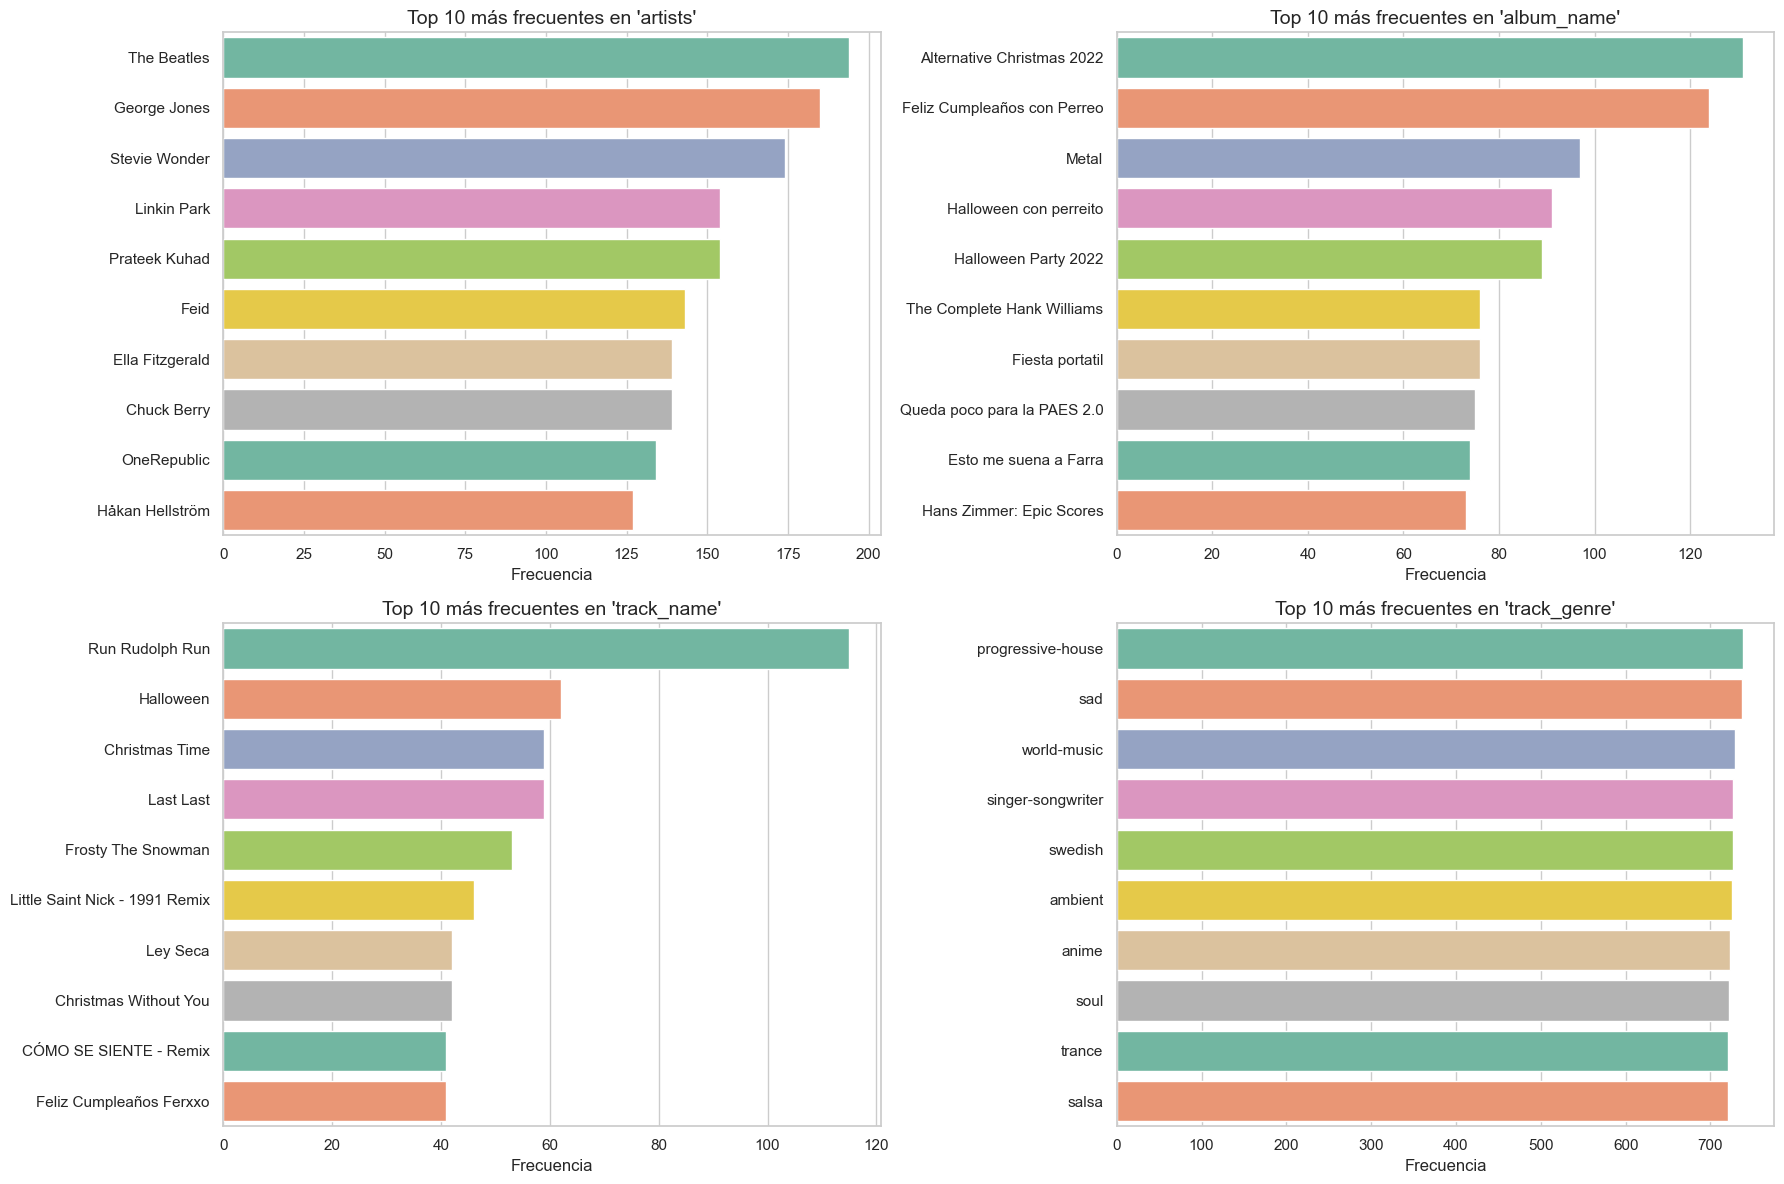

In [44]:
top_n = 10
sns.set(style='whitegrid')
palette = sns.color_palette('Set2', top_n)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()
for i, var in enumerate(variables_categoricas):
    top_values = dataTraining[var].value_counts().nlargest(top_n)
    sns.barplot(x=top_values.values, y=top_values.index, ax=axes[i], palette=palette)
    axes[i].set_title(f"Top {top_n} más frecuentes en '{var}'", fontsize=14)
    axes[i].set_xlabel("Frecuencia")
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()

Selección de variables

- Se seleccionaron las variables continuas y las variables binarias o ordinales análizadas anteriormente
- No se seleccionaron las variables con alta cardinalidad llamadas variables categoricas en el análisis anterior

In [46]:
variables_originales = [
    'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'explicit', 'key', 'mode', 'time_signature'
]

Los mejores resultados se obtuvieron con la selección de variables llamada variables_originales porque incluye únicamente características numéricas continuas y ordinales que describen de forma objetiva y estructurada los aspectos musicales de cada pista, como la energía, la acústica, el tempo o la tonalidad. Estas variables son altamente informativas, no requieren codificación adicional y están listas para ser procesadas por modelos de árbol como ExtraTrees o XGBoost. Al evitar variables categóricas de alta cardinalidad como artists, album_name o track_name, se redujo significativamente el riesgo de sobreajuste y se eliminó ruido innecesario en los datos, lo que permitió al modelo enfocarse en patrones relevantes y generalizar mejor.

# Selección del modelo

Sin variables creadas

In [50]:
dataTraining.head()

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27


Transformacion de variables

In [52]:
df =  dataTraining.copy()

- Evaluación de otros modelos basados en arboles de decisión

In [54]:
# === Variables por tipo ===
variables_continuas = [
    'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
variables_binarias_o_ordinales = ['explicit', 'key', 'mode', 'time_signature']
variables_categoricas = ['album_name', 'artists', 'track_name', 'track_genre']
target = 'popularity'

# === Preprocesamiento mínimo ===
if df['explicit'].dtype == bool:
    df['explicit'] = df['explicit'].astype(int)

X = df[variables_continuas + variables_binarias_o_ordinales + variables_categoricas].copy()
y = df[target].copy()

# Frequency encoding
for col in variables_categoricas:
    freq_map = X[col].value_counts(normalize=True).to_dict()
    X[col + '_freq'] = X[col].map(freq_map)
X.drop(columns=variables_categoricas, inplace=True)
features_finales = variables_continuas + variables_binarias_o_ordinales + [col + '_freq' for col in variables_categoricas]

# === Modelos base ===
modelos = {
    "XGBoost": XGBRegressor(verbosity=0, objective='reg:squarederror', random_state=42),
    "LightGBM": LGBMRegressor(verbose=-1, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# === Evaluación con K-Fold ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for nombre, modelo in modelos.items():
    mae_list, rmse_list, r2_list = [], [], []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx][features_finales], X.iloc[test_idx][features_finales]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))

    print(f"\nModelo: {nombre}")
    print(f"MAE Promedio:  {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
    print(f"RMSE Promedio: {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")
    print(f"R² Promedio:   {np.mean(r2_list):.2f} ± {np.std(r2_list):.2f}")


Modelo: XGBoost
MAE Promedio:  9.77 ± 0.07
RMSE Promedio: 13.34 ± 0.11
R² Promedio:   0.64 ± 0.01

Modelo: LightGBM
MAE Promedio:  10.50 ± 0.07
RMSE Promedio: 14.12 ± 0.11
R² Promedio:   0.60 ± 0.00

Modelo: RandomForest
MAE Promedio:  8.58 ± 0.09
RMSE Promedio: 12.24 ± 0.12
R² Promedio:   0.70 ± 0.01

Modelo: ExtraTrees
MAE Promedio:  8.36 ± 0.08
RMSE Promedio: 12.04 ± 0.10
R² Promedio:   0.71 ± 0.00

Modelo: GradientBoosting
MAE Promedio:  12.30 ± 0.07
RMSE Promedio: 15.92 ± 0.09
R² Promedio:   0.49 ± 0.00

Modelo: DecisionTree
MAE Promedio:  10.86 ± 0.20
RMSE Promedio: 17.65 ± 0.26
R² Promedio:   0.38 ± 0.02


- Debido a la alta cardinalidad de algunas variables categoricas su evaluo el modelo Catboost por su versatilidad para manejar variables con estas caracteristicas

In [56]:
# === 1. Variables por tipo ===
variables_continuas = [
    'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
variables_binarias_o_ordinales = ['explicit', 'key', 'mode', 'time_signature']
variables_categoricas = ['artists', 'album_name', 'track_name', 'track_genre']
target = 'popularity'

# === 2. Preprocesamiento mínimo ===
if df['explicit'].dtype == bool:
    df['explicit'] = df['explicit'].astype(int)

features = variables_continuas + variables_binarias_o_ordinales + variables_categoricas
X = df[features]
y = df[target]

# === 3. K-Fold Cross-Validation ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list = []
rmse_list = []
r2_list = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_pool = Pool(X_train, y_train, cat_features=variables_categoricas)
    test_pool = Pool(X_test, y_test, cat_features=variables_categoricas)

    model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=7,
        eval_metric='RMSE',
        random_seed=42,
        verbose=False
    )

    model.fit(train_pool)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))

# === 4. Resultados promedio ===
print(f"MAE Promedio:  {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
print(f"RMSE Promedio: {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")
print(f"R² Promedio:   {np.mean(r2_list):.2f} ± {np.std(r2_list):.2f}")


MAE Promedio:  6.32 ± 0.03
RMSE Promedio: 9.10 ± 0.05
R² Promedio:   0.83 ± 0.00


# Preprocesamiento de datos (10 puntos)

**Los datos de entrenamiento se dividen en datos de entrenamiento y validación**

En el código presentado se implementa una validación cruzada con K-Fold (5 divisiones) sobre el conjunto de entrenamiento original. Esto implica que, en cada iteración del bucle for, los datos se dividen correctamente en dos subconjuntos:

- Un subconjunto para entrenamiento (X_train, y_train)

- Un subconjunto para validación (X_test, y_test)

Esta división garantiza que el modelo se entrena únicamente con una parte del dataset y se evalúa con datos no vistos, tal como lo exige el criterio de la actividad.

Aunque el preprocesamiento aplicado es mínimo (solo la conversión de explicit a entero si es booleana), la división entre entrenamiento y validación sí se realiza correctamente y se respeta en cada fold. El modelo CatBoostRegressor se entrena exclusivamente sobre X_train y y_train, y luego se evalúa con las predicciones realizadas sobre X_test.

Por tanto, el criterio propuesto por la actividad relacionado con la correcta separación entre entrenamiento y validación sí se cumple plenamente en este código, asegurando una evaluación honesta del rendimiento del modelo sin contaminación de datos.

**Si decidieron preprocesar los datos (estandarizar, normalizar, imputar valores, etc), estos son correctamente preprocesados al ajustar sobre los datos de entrenamiento (.fit_transform()) y al transformar los datos del set de validación**

En el código presentado, la variable explicit es transformada a entero antes de realizar la validación cruzada, esta conversión no introduce ningún tipo de data leakage, ya que no depende de la distribución de los valores ni de una estadística calculada sobre el conjunto completo. Se trata simplemente de un cambio de tipo de dato determinista y uniforme, donde True pasa a 1 y False a 0.

Dado que esta transformación es independiente de los valores objetivo (popularity) y no implica ningún cálculo que podría influir en el entrenamiento o evaluación, es correcto realizarla antes de dividir los datos en los diferentes folds de validación cruzada. Es una práctica común y válida en preprocesamiento básico.

En resumen, convertir explicit a entero antes de la validación cruzada es seguro y apropiado, y no compromete la integridad del procedimiento de evaluación del modelo.

Una de las principales ventajas de los modelos basados en árboles de decisión, como los árboles de regresión, Random Forest, Gradient Boosting o métodos más avanzados como XGBoost y LightGBM, es que no requieren un preprocesamiento intensivo de los datos.

A diferencia de modelos lineales o redes neuronales, los árboles no son sensibles a la escala de las variables, por lo que no es necesario aplicar técnicas como estandarización o normalización. Además, los modelos basados en árboles pueden manejar de forma eficiente la presencia de valores atípicos y relaciones no lineales entre variables sin que estas deban ser transformadas previamente.

En el caso de las variables categóricas, muchos de estos modelos permiten codificarlas de forma simple mediante label encoding o frequency encoding, e incluso algunos los manejan internamente. Esto evita procesos más complejos como el one-hot encoding, que puede aumentar significativamente la dimensionalidad del conjunto de datos.

Por estas razones, aprovechamos la naturaleza robusta de los modelos basados en árboles para trabajar directamente con las variables originales, sin aplicar transformaciones innecesarias. Esta decisión está respaldada por la documentación oficial de estos algoritmos y representa una práctica común en problemas de predicción estructurada donde se prioriza la eficiencia sin comprometer la calidad del modelo.

Especificamente hablando de CatBoostRegressor el modelo seleccionado para la actividad, presenta una ventaja importante frente a otros tipos de algoritmos: no requieren preprocesamientos extensivos sobre los datos de entrada.

Tal como se detalla en la documentación oficial de CatBoost, este modelo puede manejar variables numéricas sin necesidad de estandarización ni normalización, y además permite el uso directo de variables categóricas sin codificarlas manualmente (por ejemplo, sin one-hot encoding o label encoding). Internamente, CatBoost utiliza métodos como ordenamiento y estadísticas de conteo para transformar automáticamente las variables categóricas durante el entrenamiento.

Gracias a estas propiedades, se reduce significativamente la carga de preprocesamiento, lo cual simplifica el flujo de trabajo y evita transformaciones que podrían introducir sesgos si no se manejan correctamente. En nuestro caso, aprovechamos esta ventaja al mantener las variables categóricas originales y al no aplicar transformaciones innecesarias sobre las variables numéricas, lo cual es coherente con las capacidades del modelo y las recomendaciones del fabricante.

In [99]:
# === Scorers personalizados ===
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# === Modelo base ===
cat_model = CatBoostRegressor(
    early_stopping_rounds=100,
    border_count=254,
    eval_metric='RMSE',
    random_seed=42,
    verbose=False
)

# === GridSearch reducido y rápido
param_grid = {
    'iterations': [300, 600, 800],
    'learning_rate': [0.03, 0.05],
    'depth': [8, 10],
    'l2_leaf_reg': [1, 3]
}

# === Ejecutar GridSearch (según RMSE)
grid = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1
)

# === Entrenamiento con variables categóricas
grid.fit(X, y, cat_features=variables_categoricas)

# === Evaluación final sobre el mismo set (referencial)
best_model = grid.best_estimator_
y_pred = best_model.predict(X)

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

# === Mostrar resultados
print("\n✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)
print(f"\nMAE total:  {mae:.2f}")
print(f"RMSE total: {rmse:.2f}")
print(f"R² total:   {r2:.2f}")


✅ Mejores hiperparámetros encontrados:
{'depth': 10, 'iterations': 800, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

MAE total:  4.62
RMSE total: 6.46
R² total:   0.92


# Modelo para la competencia de Kaggel

In [101]:
import pandas as pd
from catboost import CatBoostRegressor, Pool

# === 1. Asegurar tipos correctos y limpiar NaNs ===

# explicit a bool
dataTraining['explicit'] = dataTraining['explicit'].astype(bool)
dataTesting['explicit'] = dataTesting['explicit'].astype(bool)

# Imputar NaNs en variables categóricas SOLO en dataTesting
dataTesting['artists'] = dataTesting['artists'].fillna('unknown_artist')
dataTesting['album_name'] = dataTesting['album_name'].fillna('unknown_album')
dataTesting['track_name'] = dataTesting['track_name'].fillna('unknown_track')

# === 2. Definir variables ===
variables_continuas = [
    'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
variables_binarias_o_ordinales = ['explicit', 'key', 'mode', 'time_signature']
variables_categoricas = ['artists', 'album_name', 'track_name', 'track_genre']
features = variables_continuas + variables_binarias_o_ordinales + variables_categoricas
target = 'popularity'

# === 3. Entrenar modelo con TODO el dataTraining ===
train_pool = Pool(dataTraining[features], dataTraining[target], cat_features=variables_categoricas)

from catboost import CatBoostRegressor

from catboost import CatBoostRegressor


model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.05,
    depth=10,
    l2_leaf_reg=1,
    early_stopping_rounds=100,
    border_count=254,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)


model.fit(train_pool)

# === 4. Predecir sobre el dataTesting ===
test_pool = Pool(dataTesting[features], cat_features=variables_categoricas)
predicciones = model.predict(test_pool)

# === 5. Crear archivo de Kaggle ===
submission = pd.DataFrame({
    'ID': range(len(predicciones)),
    'Popularity': predicciones
})
submission.to_csv('submission.csv', index=False)


0:	learn: 21.6237219	total: 139ms	remaining: 1m 50s
100:	learn: 10.7241261	total: 12s	remaining: 1m 22s
200:	learn: 9.9778334	total: 25.9s	remaining: 1m 17s
300:	learn: 9.5199245	total: 40.8s	remaining: 1m 7s
400:	learn: 9.1272840	total: 55.5s	remaining: 55.2s
500:	learn: 8.8175406	total: 1m 10s	remaining: 42.3s
600:	learn: 8.5510329	total: 1m 26s	remaining: 28.6s
700:	learn: 8.3076981	total: 1m 41s	remaining: 14.4s
799:	learn: 8.0766989	total: 1m 57s	remaining: 0us


# Entrenamiento y serialización del modelo (15 puntos)

- Se entrenó usando todo el set de entrenamiento y los hiper parametros robustos para la competencia de Kaggel y asi obtener las mejores métricas como vemos en el código anterior
- Se guardo el disponibilizó el modelo en el archivo .pkl

In [ ]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import joblib

# === 1. Cargar los datos desde el archivo CSV ===
data = pd.read_csv('dataTrain_Spotify.csv')

# === 2. Separar en entrenamiento y prueba ===
dataTraining = data.sample(frac=0.8, random_state=42)
dataTesting = data.drop(dataTraining.index)

# === 3. Asegurar tipos correctos y limpiar NaNs ===
dataTraining['explicit'] = dataTraining['explicit'].astype(bool)
dataTesting['explicit'] = dataTesting['explicit'].astype(bool)

dataTesting['artists'] = dataTesting['artists'].fillna('unknown_artist')
dataTesting['album_name'] = dataTesting['album_name'].fillna('unknown_album')
dataTesting['track_name'] = dataTesting['track_name'].fillna('unknown_track')

# === 4. Definir variables ===
variables_continuas = [
    'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
variables_binarias_o_ordinales = ['explicit', 'key', 'mode', 'time_signature']
variables_categoricas = ['artists', 'album_name', 'track_name', 'track_genre']
features = variables_continuas + variables_binarias_o_ordinales + variables_categoricas
target = 'popularity'

# === 5. Entrenar modelo con TODO el dataTraining ===
train_pool = Pool(dataTraining[features], dataTraining[target], cat_features=variables_categoricas)

model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.05,
    depth=10,
    l2_leaf_reg=1,
    early_stopping_rounds=100,
    border_count=254,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

model.fit(train_pool)

# === 6. Guardar el modelo entrenado ===
joblib.dump(model, 'modelo_catboost.pkl')
